In [1]:
import datasets
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import re

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

/home/yvson/Documents/Faculdade/NLP/NLP-final-project/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')


def text_preprocess(ds: pd.Series) -> pd.Series:
    
    """
    Apply NLP Preprocessing Techniques to the reviews.
    """
    for m in range(len(ds)):
        
        main_words = re.sub('[^a-zA-Z]', ' ', ds[m])                                      # Retain only alphabets
        main_words = (main_words.lower()).split()
        main_words = [w for w in main_words if not w in set()]  # Remove stopwords
        
        lem = WordNetLemmatizer()
        main_words = [lem.lemmatize(w) for w in main_words if len(w) > 1]                 # Group different forms of the same word
        
        main_words = ' '.join(main_words)
        ds[m] = main_words

    return ds

# pegar uma porcentagem do dataset de tal modo que as classes estejam balanceadas
def get_balanced_dataset(dataset, percentage):
    import warnings
    warnings.filterwarnings("ignore", category=DeprecationWarning) 
    dataset = pd.DataFrame(dataset)
    dataset = dataset[["Noticia", "Categoria", "label"]]
    dataset = dataset.groupby("Categoria").apply(lambda x: x.sample(frac=percentage)).reset_index(drop=True)
    return dataset

def selected_categories(row):
    return row["Categoria"] in ["Política", "Internacional", "Saúde", "Ciência e Tecnologia", "Economia"]

Categories = ["Política", "Internacional", "Saúde", "Ciência e Tecnologia", "Economia"]

def catgeory2label(row):
    row["label"] = Categories.index(row["Categoria"])
    return row

[nltk_data] Downloading package stopwords to /home/yvson/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/yvson/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [30]:
dataset = datasets.load_dataset("recogna-nlp/recognasumm")
dataset = dataset.filter(selected_categories)
dataset = dataset.map(catgeory2label)

In [31]:
perc_train = 0.075
perc = 0.025

train_df = get_balanced_dataset(dataset["train"], perc_train)
teste_df = get_balanced_dataset(dataset["test"], perc)
valid_df = get_balanced_dataset(dataset["validation"], perc)

In [32]:
train_df['Noticia'] = text_preprocess(train_df['Noticia'])
teste_df['Noticia'] = text_preprocess(teste_df['Noticia'])

In [33]:
train_df

,Noticia,Categoria,label
0,Jennifer KornDavid Goldmando CNN Business Após...,Ciência e Tecnologia,3
1,Termina às 23h59 deste sábado (29) o prazo par...,Ciência e Tecnologia,3
2,A empresa comemorou o início da produção em um...,Ciência e Tecnologia,3
3,Leia mais: Em pronunciamento realizado ao lado...,Ciência e Tecnologia,3
4,"Da Reuters O YouTube bloqueou a Duma TV, que t...",Ciência e Tecnologia,3
...,...,...,...
4778,O anseio por uma vida bem-sucedida é um desejo...,Saúde,2
4779,O café é uma das bebidas mais consumidas pelo ...,Saúde,2
4780,"Pesquisadores da Universidade do Colorado, nos...",Saúde,2
4781,A portaria foi assinada pela Secretaria do Mei...,Saúde,2


In [34]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_train = tfidf_vectorizer.fit_transform(train_df["Noticia"].to_list())
tfidf_test = tfidf_vectorizer.transform(teste_df["Noticia"].to_list())

train_df['Noticia_tfdif'] = list(tfidf_train.toarray())
teste_df['Noticia_tfdif'] = list(tfidf_test.toarray())

In [35]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

model.fit(list(train_df["Noticia_tfdif"]), train_df["label"])

LogisticRegression()

In [36]:
from sklearn.metrics import classification_report

y_pred = model.predict(list(teste_df["Noticia_tfdif"]))
print(classification_report(teste_df["label"], y_pred, target_names=Categories))

                      precision    recall  f1-score   support

            Política       0.86      0.91      0.88       139
       Internacional       0.88      0.96      0.92       131
               Saúde       0.82      0.89      0.86       120
Ciência e Tecnologia       0.90      0.73      0.81        77
            Economia       0.88      0.67      0.76        63

            accuracy                           0.86       530
           macro avg       0.87      0.83      0.84       530
        weighted avg       0.86      0.86      0.86       530



In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

y_hat = model.predict(list(teste_df["Noticia_tfdif"]))
y_test = teste_df["label"].to_list()

In [38]:
#compute accuracy
accuracy =  accuracy_score(y_test, y_hat, average='macro')
print(f"Accuracy: {accuracy}")

#compute recall
recall = recall_score(y_test, y_hat, average='macro')
print(f"Recall: {recall}")

#compute precision
precision = precision_score(y_test, y_hat, average='macro')
print(f"Precision: {precision}")

#compute f1 score
f1 = f1_score(y_test, y_hat, average='macro')
print(f"F1 Score: {f1}")

Accuracy: 0.8622641509433963
Recall: 0.8307825883637296
Precision: 0.8679128935580549
F1 Score: 0.8438678125512343


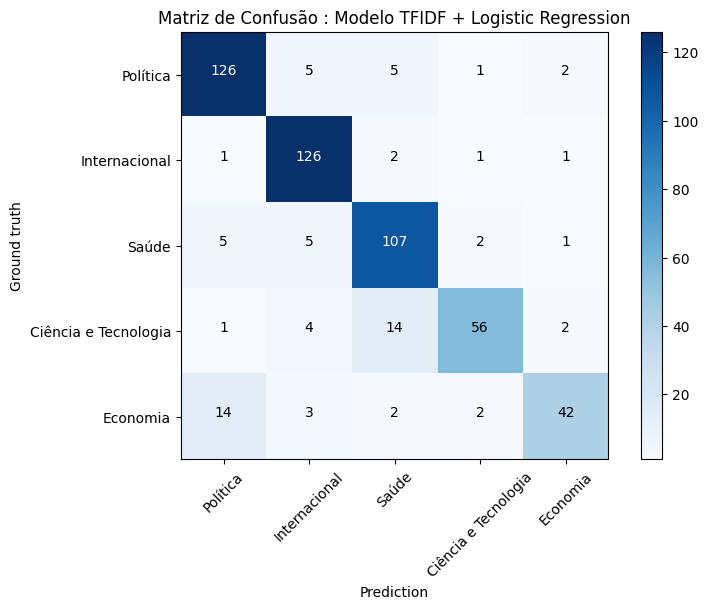

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

conf_matrix = confusion_matrix(y_test, y_hat)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusão : Modelo TFIDF + Logistic Regression')
plt.colorbar()


tick_marks = np.arange(len(Categories))
plt.xticks(tick_marks, Categories, rotation=45)
plt.yticks(tick_marks, Categories)


thresh = conf_matrix.max() / 2.
for i, j in [(i, j) for i in range(conf_matrix.shape[0]) for j in range(conf_matrix.shape[1])]:
    plt.text(j, i, conf_matrix[i, j], horizontalalignment="center", color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('Ground truth')
plt.xlabel('Prediction')
plt.show()